<img src="files/indeed.png" style="float: right; height: 100px">


# Indications for Different Types of Jobs on Indeed.com
---
### Goals:
- Determine best indicators of salary range:
    - Skills? 
    - Words? 
    - Experience Required?
    - Education Required?
- Explore unsupervised methods
    - Determine which words indicate which industries

---
# Data Scientist:
<img src="files/circle_wordcloud_ds.png" style="float: left; height: 600px">

---
# Data Analyst:
<img src="files/circle_wordcloud_da.png" style="float: left; height: 600px">

---
### Findings:
- 'Ensemble technique' of both bag of words and specific keywords was the best
    - Regex .03 better than .68 baseline
    - Bag of Words .10 better than .44 baseline
    - Both produced ~.15-.17 better than .44 baseline
- Optimizing each set of approach individually seems powerful
    - I went through optimizing both title and summary which lead to difficulties
    - Whereas I optimized the keywords separately
- By weighting different categorical variables I was able to boost my accuracy:
    - Example: {np.nan:10,'Educación':1,'High':1,'Associate':2,'Bachelor':20,'Master':60,'Doctorate':500}

---

<img src="files/advanced_search.png" style="float: right; height: 400px">
### 3 Sets of Data:
- Labeled Salary data for 5 job types:
    - Salary ranges based on Indeed's advanced search metric:
        - '30k-70k', '70k-100k', '100k-130k', '130k-250k'
    - Phrases searched:

        - Data Scientist, Data Analyst, Research Scientist, Business Intelligence, and Business Analyst
    - Locations searched:
        - Washington DC, Boston, New York
- Unlabeled Junior and Senior positions
    - Title searched:
        - Junior, Senior
- Unlabeled set of 5 Industries:
    - Phrases searched:
        -Government, Healthcare, Manufacturing, Banking, Insuarance

---
### Assumptions/Constraints:
- Only pulled from Indeed website postings, due to consistent format
    - We are assuming that Indeed postings are representitive of all job postings
- ~10% of listings on Indeed are internal Indeed listings
    - To increase sample size I pulled job listings from multiple metro regions
    - Salary differences are negligable across the locations sampled

---

### Format - Indeed vs Other:
<img src="files/other.png" style="float: right; height: 450px">
<img src="files/indeed_post.png" style="float: left; height: 450px">


---
<img src="files/joblist.png" style="float: right; height: 450px">
## Agregatting the data:
- Two steps:
    - __Tier1__: Save all urls in a dataframe
    - __Tier2__: Save the html data for each url to parse later
- Result:
    - End up with 3 master.csvs to run analysis on

---
### Tier 1:
- Manipulate the Indeed advanced search url to pull jobs accordingly:
    - Generate link for each job listings page
        - Luckily this can be incremented by 50 per page
    - Loop through all pages until last job
        - Change the start=50 in url to see jobs 50-100
    - Save search metadata like 'search_phrase','salary','location' etc for each url
        - To use as target variables later on

In [533]:
#search terms
phrase = 'data+science'
loc = 'Boston%2C+MA'
by = '50'
sal = '50k-=100k'

#function to generate link
gen_link(phrase=phrase,sal=sal,loc=loc,title='')

'https://www.indeed.com/jobs?as_and=&as_phr=data+science&as_any=&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=50k-=100k&radius=50&l=Boston%2C+MA&fromage=any&limit=50&start=0'

In [ ]:
def search_many(phrase,sal='',anyy='',loc='Boston%2C+MA',title=''):
    '''
    Requires:
        phrase: 'data+science'
        sal: '10k-100k'
        anyy (any words that match): 'python+matplotlib+etc'
        loc: 'Boston, MA'
    '''

    master_dict = {}
    i = 0
    by = '50'
    
    #construct link
    #link = 'https://www.indeed.com/jobs?as_and=&as_phr=' + str(phrase) + '&as_any=' + str(anyy) + '&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=' + str(sal) + '&radius=50&l=' + str(loc) + '&fromage=any&limit=' + str(by) + '&start=' + str(i)# + 'sort=&psf=advsrch'
    link = gen_link(phrase,sal,anyy,loc,title)
    link_numbered = link

    #notify user of total postings
    status = page(link).xpath(main_xpath['job_count'])[0].split()[-1]
    last_status = ''
    print(' ----- ' + str(status) + ' listings ----- ')
    postings = page(link).xpath(main_xpath['job_count'])[0].split()[-1].replace(',','')
    
    #ask for the go ahead
    #if go_ahead('Continue?') == True:

    #added because it wouldn't stop when expected and there would never be over 1500 jobs
    postings = 1500
    
    #while last_status != page(link_numbered).xpath(main_xpath['job_count'])[0].split()[-1]:
    while i < int(postings):
        #generate last status
        #last_status = page(link_numbered).xpath(main_xpath['job_count'])[0].split()[-1]        

        #generate next numbered link
        link_numbered = link + str(i)
        #print(link_numbered)

        #print current state of jobs
        print(page(link_numbered).xpath(main_xpath['job_count']))

        #lists of
        titles = page(link_numbered).xpath(main_xpath['job_title'])
        urls = page(link_numbered).xpath(main_xpath['job_url'])
        ids = page(link_numbered).xpath(main_xpath['job_id2'])
        salaries = [sal]*len(ids)
        phrases = [phrase]*len(ids)
        locs = [loc]*len(ids)

        #add the data
        for job, url, iden, sal, phra, loc in zip(titles,urls,ids,salaries,phrases,locs):
            master_dict[iden] = [job,url,sal,phra,loc]

        #followup
        i += int(by)
    print(' ----- Done ----- ')
    #else:
        #print(' ----- Cancelled ----- ')
    return master_dict

In [ ]:
#function dictionary to df with formatted url
def to_df(master_dict,save=False,save_name=''):
    df = pd.DataFrame(master_dict).T
    df.columns=['title','url','sal','search_phrase','search_loc']
    df['url'] = 'https://www.indeed.com' + df['url']
    df['frmt'] = df['url'].apply(lambda url: 'https://www.indeed.com/company' in url)
    if save == True:
        df.to_csv(save_name,index=False)
    return df

In [ ]:
#loop though search terms
dst_link_dict = {}

#loc = 'Washington%2C+DC'
loc = 'New+York%2C+NY'
#loc = 'Boston%2C+MA'
by = '50'

#phrase='data+science'
#phrase='machine+learning'
#phrase='data+scientist'
#phrase='data+analyst'
#phrase='research+scientist'
#phrase='business+intelligence'
#phrase='business+analyst'

phrases = ['machine+learning','data+scientist','data+analyst',
            'research+scientist','business+intelligence','business+analyst',]

#for each phrase
for phrase in phrases:
    dst_link_dict = {}
    
    #run pull urls
    sal_list = ['30k-70k','70k-100k','100k-130k','130k-250k']
    for sal in sal_list:
        #link = 'https://www.indeed.com/jobs?as_and=&as_phr=' + str(phrase) + '&as_any=' + str(anyy) + '&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=' + str(sal) + '&radius=50&l=' + str(loc) + '&fromage=any&limit=' + str(by) + '&sort=&psf=advsrch'
        #link = gen_link(phrase,sal=sal)
        dst_link_dict[sal] = search_many(phrase,sal,loc=loc)

    #save all salaries in csvs in local folder
    for sal in sal_list:
        df = to_df(dst_link_dict[sal],True,'Phrase'+str(phrase)+str(loc)+str(sal)+'.csv')

---
### Tier 2:

- Group all csvs with the filenames including 'phrase' in the local folder
    - Builds a single dataframe with all these
- Drop non-Indeed listings
    - frmt = 1 means Indeed listing
- Apply add_html function to url col
- Apply other functions for 'job_title','job_location','company_name' etc.

In [ ]:
def add_html(url):
    response = requests.get(url)
    return response.text

In [ ]:
def dl_html(phrase,path='./'):
    import glob
    #grab all csvs with that name
    globbed_csvs = glob.glob(path + "*" + str(phrase) + "*.csv")

    print('----- Combining dfs -----')

    #put them in a single df
    combined_df = pd.DataFrame()
    df_list = []
    for f in globbed_csvs:
        dfn = pd.read_csv(f, header=0,encoding = "ISO-8859-1") #index=False
        df_list.append(dfn)
    combined_df = pd.concat(df_list)
    
    #only keep indeed listings
    combined_df = combined_df[combined_df['frmt'] == 1]
    
    #drop_duplicates based on unique url
    combined_df = combined_df.drop_duplicates(subset=['url'])
    
    #add blank col
    combined_df['html'] = ''
    
    print('----- Adding Html -----')
    
    #download the html and put it in the combined df
    combined_df['html'] = combined_df['url'].apply(add_html)
        
    return combined_df

In [ ]:
#list index out o frange.. 'machine+learning'
phrases = ['data+scientist', 'data+analyst'
           'research+scientist','business+intelligence','business+analyst']

for save_name in phrases:
    df = pd.DataFrame()
    
    
    df = dl_html(save_name)

    df['comp_name'] = df['html'].apply(parse_comp_name)
    df['job_title'] = df['html'].apply(parse_job_title)
    df['job_loc'] = df['html'].apply(parse_job_loc)
    df['job_summary'] = df['html'].apply(parse_job_summary)
    df['job_summary'] = df['job_summary'].apply(str_summary)

    df.to_csv(save_name+'.csv')

---
### Explore 3 Master dfs:
Create 3 master df's to work off of:
    - industry_df - for LDA and topic clustering practice
        - search_phrase = 'government' or 'healthcare' etc.
    - salary_df - for salary classification
        - sal = '100k-130k', '130k-250k', '30k-70k', '70k-100k'
    - juniorsenior_df - for attempt to differentiate keywords
        - title = 'junior' or 'senior'

---
### Duplicates, Numerics?
- Found duplicates in my initial investigation so added a delete duplicates before the download html function so I didn't waste time
- Add numeric target for ML later

In [535]:
ind_df = pd.read_csv('industry_df.csv',encoding='latin1')
js_df = pd.read_csv('juniorsenior_df',encoding='latin1')
sal_df = pd.read_csv('salary_df.csv',encoding='latin1')

In [537]:
print(ind_df.shape)
print(sal_df.shape)
print(js_df.shape)

(741, 14)
(1122, 14)
(540, 14)


In [538]:
sal_df.head(1)

,Unnamed: 0,Unnamed: 0.1,title,url,sal,search_phrase,search_loc,frmt,html,comp_name,job_title,job_loc,job_summary,sal_num
0,0,205,Marketing Analyst,https://www.indeed.com/company/GS-Global-Servi...,30k-70k,business+intelligence,New+York%2C+NY,True,"<!DOCTYPE html>\r\r\n<html lang=""en"">\r\r\n<he...",GS Global Services Inc.,Jr. Systems/Data Analyst - SQL SSIS,"New York, NY",?Candidates requiring visa sponsorship in futu...,0


---
## Salary_df:
- There are 4 salary levels: '30k-70k','70k-100k','100k-130k','130k-250k'
- There are 5 job types: 'business+intelligence', 'business+analyst', 'research+scientist','data+analyst', 'data+scientist'


- Try to pull indicating words directly
- Use CountVectorizer to find indicative words and phrases

In [544]:
df['search_phrase'].value_counts()

business+analyst         411
business+intelligence    407
data+analyst             183
data+scientist            92
research+scientist        29
Name: search_phrase, dtype: int64

In [540]:
df['sal'].value_counts()

70k-100k     497
100k-130k    282
30k-70k      268
130k-250k     75
Name: sal, dtype: int64

In [539]:
#baseline for predicting 1 of 4 groups
df['sal'].value_counts().max()/df['sal'].count()

0.44295900178253117

In [578]:
#baseline for predicting 1 of 2 groups (30k-100k or 100k-250k)
(268 + 497) / df['sal'].count()

0.68181818181818177

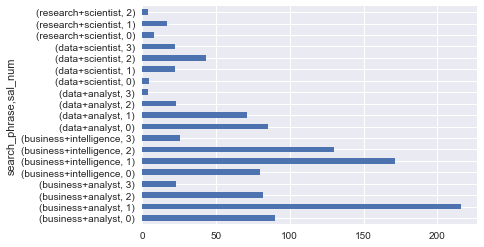

In [1371]:
df.groupby(['search_phrase','sal_num']).size().plot.barh()

---
### Use regex to find key phrases:
By investigating I found pretty common phrases:
    - 'Required education:' in 54% of all listings
    - 'Required experience:' in 65% of all listings
Find 'high value' phrases:
    - 'PhD' and various spellings
    - I would have liked to include a list of skills based on price bracket here but didn't have time
        - Valuable: 'Hadoop','Spark','AWS','R','python','svm' etc.
        - Less valuable: 'excel','microsoft' etc.
I also wanted to pull the number before the word year/years for phrases like:
    - 2-4 years experience required.
    - 5+ years experience in data science prefered.

In [555]:
#education
edu = df['job_summary'].str.extract('((Required education: )\w+)',expand=False)
edu_col = edu[0].str.extract(r': (\w+)',expand=False)
edu_col.value_counts()

Bachelor     529
Master        53
Doctorate     10
High          10
Associate     10
Educación      1
Name: 0, dtype: int64

In [1123]:
#map the values according to my assumptions of each value
edu_col = edu_col.map({np.nan:10,'Educación':1,'High':1,'Associate':2,'Bachelor':20,'Master':60,'Doctorate':500})

In [1124]:
edu[0].count()/len(edu)

0.54634581105169344

In [1125]:
#experience
exp = df['job_summary'].str.extract('((Required experience: ).+)',expand=False)
exp_col = exp[0].str.extractall(r'(\d+)\syear')
exp_col = pd.to_numeric(exp_col[0])
exp_col = exp_col.groupby(level=[0]).sum()

In [1126]:
exp[0].count()/len(exp)

0.65418894830659535

In [1127]:
phd_col = df['job_summary'].str.extract('(PHD|phd|PhD|P.h.D.)',expand=False)
phd_col = phd_col.map({np.nan:0,'PhD':5})

In [1128]:
#best so far for numerics before year
#job_df = df['job_summary'].str.extract('([\d\S+-A-Z]+[\W\D]+(years|year))',expand=False)
#job_df.to_csv('years.csv',index=False)

In [1129]:
job_col.head()

,,0,1,2
,match,,,
0,0,2,-,4
4,0,0,-,1
6,0,2,+,NaN
7,0,6,NaN,NaN
8,0,2,+,NaN


In [1265]:
#pulling number before word: year|years
job = pd.read_csv('years.csv')
job_col = job['0'].str.extractall(r'(\d)(\S?)(\d*)\syear')
y_min = job_col[0]
y_ind = job_col[1]
#y_ind = y_ind.map({'-':10,'+':100})
y_max = job_col[2]
y_min = pd.to_numeric(y_min)
y_max = pd.to_numeric(y_max)
y_min = y_min.groupby(level=[0]).sum()
y_max = y_max.groupby(level=[0]).sum()
#y_max = y_max*20
y_ind = y_ind.groupby(level=[0]).unique()

In [1266]:
group = [edu_col,exp_col,phd_col,y_min,y_max]
ext_df = pd.concat(group,axis=1)

In [1267]:
ext_df = ext_df.fillna(0)

In [1268]:
X = ext_df
y = df['sal_num']
#break sal into 
y = y.map({0:0,1:0,2:1,3:1})

In [1269]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)

In [1270]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4)

In [1271]:
#baselines:
# .44
# .682

In [1272]:
#clf = RandomForestClassifier(n_estimators=200,random_state=42,criterion='entropy') #did very poorly on 
#clf = RandomForestClassifier(n_estimators=200,random_state=42,criterion='gini')
#clf = LogisticRegression(penalty='l1',C=10) #.454 with l1,c=10  #C=1,L1,.639
#clf = LogisticRegression() #job only, .64
#clf = MultinomialNB()
#clf = SVC(C=1,kernel='poly',degree=2) #takes waaaay too long
#clf = SVC(C=10,gamma=10,kernel='linear',random_state=42) #c=10,.646 (both job+title)
clf = KNeighborsClassifier(n_neighbors=10,metric='manhattan') #.732 with 35,manhattan, now .71
#clf = KNeighborsClassifier(n_neighbors=25)#,metric='manhattan') #.732 with 35,manhattan, now .71

In [1273]:
clf.fit(X_train,y_train)
#cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
cross_val_score(clf,X_train,y_train,cv=10).mean()

0.65817968978636232

In [1274]:
y_pred = clf.predict(X_test)

In [1275]:
clf.score(X_test,y_test)

0.71046770601336307

In [1276]:
confusion_matrix(y_pred, y_test)

array([[290, 110],
       [ 20,  29]])

---
### Bag of Words Approach

Use CountVectorizer to create bag of words for:
    - Job titles
    - Job summarys
    
Count Vectorizer:
    - min_df, max_df were very important when trimming words from the initial bag.
    - n_grams 1,3 were most indicative
    - output:
        - ~20k for job summary
        - ~227 for job title

NMF:
    - Further trim words down to a reasonable size with L1 regularization
    - Give the ability to select # of topics like 
    - Can examine the output to see which topics its creating

Multiply NMF back against Bag of Words:
    - Creates a sparse matrix with word counts weighted by their NMF score

Added the regex data from above which increased the score by ~5%

In [2684]:
X_job = df['job_summary']
X_title = df['job_title']
y_all = df['sal_num']

In [2685]:
#create bag of words for job summary
cvt_job      =  CountVectorizer(stop_words=stop,
                            strip_accents='unicode', 
                            ngram_range=(1,3),
                            max_df=.84, #was. 84
                            min_df=4, #was 4
                            tokenizer=LemmaTokenizer())
X_job_cvt    =  cvt_job.fit_transform(X_job)

In [2686]:
#create bag of words for job title
cvt_title      =  CountVectorizer(stop_words=stop,
                            strip_accents='unicode', 
                            ngram_range=(1,2),
                            max_df=.7,
                            min_df=5, #was 5
                            tokenizer=LemmaTokenizer())
X_title_cvt    =  cvt_title.fit_transform(X_title)

In [2687]:
print(X_job_cvt.shape)
print(X_title_cvt.shape)

(1122, 20886)
(1122, 171)


In [2688]:
tf_job = TfidfTransformer()
X_job = tf_job.fit_transform(X_job_cvt)

tf_title = TfidfTransformer()
X_title = tf_title.fit_transform(X_title_cvt)

In [2689]:
n_titles=5
n_jobs=4

nmf_title = NMF(n_components=n_titles, #was 8
          random_state=42, 
          alpha=.12, #was .12
          l1_ratio=.9, 
          init='nndsvd').fit(X_title)

nmf_job = NMF(n_components=n_jobs, #was 4
          random_state=42, 
          alpha=.15, #was .15
          l1_ratio=.7, 
          init='nndsvd').fit(X_job)

In [2690]:
nmf_job_df = pd.DataFrame(nmf_job.components_, columns = cvt_job.get_feature_names())
nmf_job_df = nmf_job_df.replace(0,np.nan)
nmf_job_df = nmf_job_df.dropna(how='all',axis=1)
nmf_job_df = nmf_job_df.replace(np.nan,0)

nmf_title_df = pd.DataFrame(nmf_title.components_, columns = cvt_title.get_feature_names())
nmf_title_df = nmf_title_df.replace(0,np.nan)
nmf_title_df = nmf_title_df.dropna(how='all',axis=1)
nmf_title_df = nmf_title_df.replace(np.nan,0)

In [2691]:
print(nmf_job_df.shape)
print(nmf_title_df.shape)

(4, 2037)
(5, 92)


---
### NMF keywords found for each bag of words:
Job Title:
    - data, learning, machine, machine learning, scientist
    - project, requirement, system, data, team
    - sale, customer, account, product, prospect
    - salient, n/a, government, crgt, salient crg <- In Washington DC theyre hiring like 180 data analysts at cgrt
Job Summary:
    - business analyst, business, analyst, senior business, senior
    - data analyst, data, analyst, analyst, senior data, senior
    - scientist, data scientist, data, research, research scientist <- Interesting to see it sees research scientists similar to data scientists
    - developer, senior, etl, sharepoint dev, software dev
    - manager, project, project manager, senior, business

In [2705]:
nmf_job_df.T.sort_values(3,ascending=False).head()

,0,1,2,3
salient,0.00000,0.0,0.0,0.282601
n/a,0.00000,0.0,0.0,0.181486
government,0.05827,0.0,0.0,0.114894
crgt,0.00000,0.0,0.0,0.114006
salient crgt,0.00000,0.0,0.0,0.114006


In [2793]:
nmf_title_df.T.sort_values(2,ascending=False).head()

,0,1,2,3,4
scientist,0.0,0.000000,3.500644,0.000000,0.000000
data scientist,0.0,0.000000,3.181482,0.000000,0.000000
data,0.0,4.293569,2.385226,0.059512,0.002343
research,0.0,0.043742,0.455421,0.000000,0.000000
research scientist,0.0,0.000000,0.381193,0.000000,0.000000


In [2695]:
#create a single feature set with both reduced bag of words models
X_nmf = pd.DataFrame()
#for i, j in enumerate(['gov','manu','bank','health','insurance']):
for i in range(n_jobs):
    X_nmf = pd.concat([X_nmf,pd.DataFrame(np.matmul(X_job_cvt.toarray(),nmf_job.components_[i]),columns=[i])],axis=1)
for i in range(n_titles):
    X_nmf = pd.concat([X_nmf,pd.DataFrame(np.matmul(X_title_cvt.toarray(),nmf_title.components_[i]),columns=[i])],axis=1)
X_nmf = pd.concat([X_nmf,ext_df],axis=1)

In [2696]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X_nmf)

In [2697]:
#X = df['job_summary']
#X = X_nmf
#y = df['title_num']
y = df['sal_num']
#y = df['search_phrase']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4)

In [2698]:
clf = RandomForestClassifier(n_estimators=150,random_state=42,criterion='entropy') 
#150,entropy .57 with 3,4,.12,.15, job and title and sal info, after fixed the X_nmf thing
#150,entropy .594 with 3,9,.12,.15, job and title and sal info, after fixed the X_nmf thing
#150,entropy .572 with 5,5,.12,.15, job and title and sal info, after fixed the X_nmf thing
#150,entropy .623 with nmfs 5,5, max_df 4,5, job and title and sal info, after fixed the X_nmf thing

#clf = LogisticRegression(penalty='l2',C=10) #C=1,L1,.639 (job only)
#clf = LogisticRegression() #job only, .64
#clf = KNeighborsClassifier(n_neighbors=25)#,metric='manhattan')
#clf = SVC(C=10,gamma=10,kernel='linear',random_state=42) #c=10,.646 (both job+title)

In [2699]:
clf.fit(X_train,y_train)
#cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
cross_val_score(clf,X_train,y_train,cv=10).mean()

0.54647681325812414

In [2700]:
y_pred = clf.predict(X_test)
y_total_pred = clf.predict(X_nmf)

In [2701]:
from sklearn.metrics import confusion_matrix

In [2702]:
clf.score(X_test,y_test)

0.59242761692650336

In [2643]:
confusion_matrix(y_pred, y_test)

array([[ 60,  30,   1,   3],
       [ 53, 138,  51,  13],
       [  5,  30,  48,   9],
       [  0,   0,   2,   6]])

---
### NMF investigation to cluster industry jobs:

In [2712]:
df = pd.read_csv('industry_df.csv',encoding='latin1') #EDA different clusters of words
#df = pd.read_csv('juniorsenior_df',encoding='latin1') #94% with randomforrest nmf
#df = pd.read_csv('salary_df.csv',encoding='latin1') #15% above baseline

In [2714]:
X_job = df['job_summary']
y_all = df['search_phrase_num']

#create bag of words for job summary
cvt_job      =  CountVectorizer(stop_words=stop,
                            strip_accents='unicode', 
                            ngram_range=(1,3),
                            max_df=.86, #was. 84
                            min_df=4, #was 4
                            tokenizer=LemmaTokenizer())
X_job_cvt    =  cvt_job.fit_transform(X_job)

In [2716]:
tf_job = TfidfTransformer()
X_job = tf_job.fit_transform(X_job_cvt)

In [2717]:
n_jobs=5

nmf_job = NMF(n_components=n_jobs, #was 4
          random_state=42, 
          alpha=.15, #was .15
          l1_ratio=.7, 
          init='nndsvd').fit(X_job)

In [2718]:
nmf_job_df = pd.DataFrame(nmf_job.components_, columns = cvt_job.get_feature_names())
nmf_job_df = nmf_job_df.replace(0,np.nan)
nmf_job_df = nmf_job_df.dropna(how='all',axis=1)
nmf_job_df = nmf_job_df.replace(np.nan,0)

---
### Output is pretty close to what I'd expect:
    - 0: Insurance though low on list
    - 1: Manufacturing
    - 2: Customer Service/Business
    - 3: Healthcare
    - 4: Loans/Banking
    
Clustering shows the similarity between Healthcare dealing with insurance, and the Insurance dealing with medical things

In [2805]:
nmf_job_df.T.sort_values(4,ascending=False).head(10)

,0,1,2,3,4
loan,0.014644,0.0,0.000000,0.0,1.310840
mortgage,0.000000,0.0,0.000000,0.0,0.697917
loan officer,0.000000,0.0,0.000000,0.0,0.165804
officer,0.000000,0.0,0.000000,0.0,0.088668
borrower,0.000000,0.0,0.000000,0.0,0.067988
bank,0.075249,0.0,0.191452,0.0,0.044879
credit,0.054554,0.0,0.000000,0.0,0.044096
consumer loan,0.000000,0.0,0.000000,0.0,0.034207
client,0.349772,0.0,0.000000,0.0,0.033000
servicing,0.004197,0.0,0.000000,0.0,0.027114


---
### Discussion:
Would have liked to pull keywords for individual salary levels
    - Would be difficult to find similaritis across disciplines, so I would have had to separate each job title and then levels of salary
There is a lot of power in weak models
    - Realizing the benefit of adding the keywords on top of the NMF bag of words technique

---
## In the shape of a laptop... "Data Scientist" Job words

<img src="files/my_wordcloud_2.png" style="float: left; height: 600px">

---
### Conclusion:
Unstructured data is challenging
    - There is a ton of information hidden within it
    - It seems like the simplest technique is to manually pull 
        - keywords
        - key indicators
        - however this isn't scalable
    - It is very cool to see NMF custer relevant words - though using it to classify wasn't a good use case